In [73]:
from sklearn import *
import sklearn
import pandas as pd
import numpy as np
import xgboost as xgb
import os

train = pd.read_csv('data/training_variants')
test = pd.read_csv('data/test_variants')
trainx = pd.read_csv('data/training_text', sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
testx = pd.read_csv('data/test_text', sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])

train = pd.merge(train, trainx, how='left', on='ID').fillna('')
y = train['Class'].values
train = train.drop(['Class'], axis=1)

test = pd.merge(test, testx, how='left', on='ID').fillna('')
pid = test['ID'].values

In [74]:
if 'test_df' not in os.listdir():
    df_all = pd.concat((train, test), axis=0, ignore_index=True)
    df_all['Gene_Share'] = df_all.apply(lambda r: sum([1 for w in r['Gene'].split(' ') if w in r['Text'].split(' ')]), axis=1)
    df_all['Variation_Share'] = df_all.apply(lambda r: sum([1 for w in r['Variation'].split(' ') if w in r['Text'].split(' ')]), axis=1)

    for i in range(56):
        df_all['Gene_'+str(i)] = df_all['Gene'].map(lambda x: str(x[i]) if len(x)>i else '')
        df_all['Variation'+str(i)] = df_all['Variation'].map(lambda x: str(x[i]) if len(x)>i else '')


    gen_var_lst = sorted(list(train.Gene.unique()) + list(train.Variation.unique()))
    print(len(gen_var_lst))
    gen_var_lst = [x for x in gen_var_lst if len(x.split(' '))==1]
    print(len(gen_var_lst))
    i_ = 0
    
    for gen_var_lst_itm in gen_var_lst:
        if i_ % 100 == 0: print(i_)
        df_all['GV_'+str(gen_var_lst_itm)] = df_all['Text'].map(lambda x: str(x).count(str(gen_var_lst_itm)))
        i_ += 1

    for c in df_all.columns:
        if df_all[c].dtype == 'object':
            if c in ['Gene','Variation']:
                lbl = preprocessing.LabelEncoder()
                df_all[c+'_lbl_enc'] = lbl.fit_transform(df_all[c].values)  
                df_all[c+'_len'] = df_all[c].map(lambda x: len(str(x)))
                df_all[c+'_words'] = df_all[c].map(lambda x: len(str(x).split(' ')))
            elif c != 'Text':
                lbl = preprocessing.LabelEncoder()
                df_all[c] = lbl.fit_transform(df_all[c].values)
            if c=='Text': 
                df_all[c+'_len'] = df_all[c].map(lambda x: len(str(x)))
                df_all[c+'_words'] = df_all[c].map(lambda x: len(str(x).split(' '))) 
    df_all.to_pickle('df_all')
else:
    df_all =  pd.read_pickle('test_df')
    print('Using saved DataFrame')
train = df_all.iloc[:len(train)]
test = df_all.iloc[len(train):]

In [75]:
class cust_regression_vals(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        x = x.drop(['Gene', 'Variation','ID','Text'],axis=1).values
        return x

class cust_txt_col(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        return x[self.key].apply(str)


In [76]:
fp = pipeline.Pipeline([
    ('union', pipeline.FeatureUnion(
        n_jobs = -1,
        transformer_list = [
            ('standard', cust_regression_vals()),
            ('pi1', pipeline.Pipeline([
                ('Gene', cust_txt_col('Gene')), 
                ('count_Gene', feature_extraction.text.CountVectorizer(analyzer=u'char', ngram_range=(1, 8))), 
                ('tsvd1', decomposition.TruncatedSVD(n_components=20, n_iter=25, random_state=12))])),
            ('pi2', pipeline.Pipeline([
                ('Variation', cust_txt_col('Variation')), 
                ('count_Variation', feature_extraction.text.CountVectorizer(analyzer=u'char', ngram_range=(1, 8))),
                ('tsvd2', decomposition.TruncatedSVD(n_components=20, n_iter=25, random_state=12))])),
            ('pi3', pipeline.Pipeline([
                ('Text', cust_txt_col('Text')), 
                ('tfidf_Text', feature_extraction.text.TfidfVectorizer(ngram_range=(1, 2),stop_words='english',max_df=0.6)), 
                ('tsvd3', decomposition.TruncatedSVD(n_components=30, n_iter=25, random_state=12))]))
        ])
    )])


In [77]:

train = fp.fit_transform(train); print(train.shape)
test = fp.transform(test); print(test.shape)


(3321, 3283)
(5668, 3283)


In [78]:
y = y - 1 

denom = 0
fold = 5 
for i in range(fold):
    params = {
        'eta': 0.02,
        'max_depth': 3,
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class': 9,
        'subsample':0.5,
        'lambda':1.1,
        'seed': i,
        'silent': True
    }
    x1, x2, y1, y2 = model_selection.train_test_split(train, y, test_size=0.18, random_state=i)
    watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
    model = xgb.train(params, xgb.DMatrix(x1, y1), 1000,  watchlist, verbose_eval=50, early_stopping_rounds=100)
    score1 = metrics.log_loss(y2, model.predict(xgb.DMatrix(x2), ntree_limit=model.best_ntree_limit), labels = list(range(9)))
    print(score1)
    #if score < 0.9:
    if denom != 0:
        pred = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit+80)
        preds += pred
    else:
        pred = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit+80)
        preds = pred.copy()
    denom += 1
    submission = pd.DataFrame(pred, columns=['class'+str(c+1) for c in range(9)])
    submission['ID'] = pid
    submission.to_csv('submission_xgb_fold_'  + str(i) + '.csv', index=False)
preds /= denom


[0]	train-mlogloss:2.16802	valid-mlogloss:2.17092
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[50]	train-mlogloss:1.44347	valid-mlogloss:1.53615
[100]	train-mlogloss:1.16242	valid-mlogloss:1.30614
[150]	train-mlogloss:1.00354	valid-mlogloss:1.19071
[200]	train-mlogloss:0.899181	valid-mlogloss:1.124
[250]	train-mlogloss:0.822166	valid-mlogloss:1.08491
[300]	train-mlogloss:0.756596	valid-mlogloss:1.05467
[350]	train-mlogloss:0.701488	valid-mlogloss:1.03061
[400]	train-mlogloss:0.653639	valid-mlogloss:1.01534
[450]	train-mlogloss:0.612131	valid-mlogloss:1.00398
[500]	train-mlogloss:0.573183	valid-mlogloss:0.991376
[550]	train-mlogloss:0.53843	valid-mlogloss:0.982433
[600]	train-mlogloss:0.507069	valid-mlogloss:0.973223
[650]	train-mlogloss:0.478067	valid-mlogloss:0.966912
[700]	train-mlogloss:0.451336	valid-mlogloss:0.961951
[750]	train-mlogloss:0.427012	valid-mlogloss:0.958795
[8

^
* Many parameters to tune still, work in progress
* overfitting seems to be a bit reduced, not ideal yet though
* ngram(1,3) and tfIdf parameters to tune. Resource issues :( Memory 
* adding smote pipeline (yet to check quality of upsampling)

[0]	train-mlogloss:2.14454	valid-mlogloss:2.15158
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[50]	train-mlogloss:1.17988	valid-mlogloss:1.32827
[100]	train-mlogloss:0.905796	valid-mlogloss:1.15435
[150]	train-mlogloss:0.765707	valid-mlogloss:1.08387
[200]	train-mlogloss:0.673952	valid-mlogloss:1.04956
[250]	train-mlogloss:0.602869	valid-mlogloss:1.02886
[300]	train-mlogloss:0.545822	valid-mlogloss:1.01569
[350]	train-mlogloss:0.497314	valid-mlogloss:1.00831
[400]	train-mlogloss:0.455515	valid-mlogloss:1.00382
[450]	train-mlogloss:0.418842	valid-mlogloss:0.99966
[500]	train-mlogloss:0.387101	valid-mlogloss:0.9979
[550]	train-mlogloss:0.358684	valid-mlogloss:0.996015
[600]	train-mlogloss:0.3345	valid-mlogloss:0.996067
[650]	train-mlogloss:0.311781	valid-mlogloss:0.997598
Stopping. Best iteration:
[562]	train-mlogloss:0.353024	valid-mlogloss:0.995442

0.995442350305
---------------------------
lambda=1 & subsample = 0.6
---------------------------
[0]	train-mlogloss:2.14692	valid-mlogloss:2.15293
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[50]	train-mlogloss:1.1641	valid-mlogloss:1.31774
[100]	train-mlogloss:0.873756	valid-mlogloss:1.13325
[150]	train-mlogloss:0.717084	valid-mlogloss:1.0625
[200]	train-mlogloss:0.606108	valid-mlogloss:1.02755
[250]	train-mlogloss:0.520314	valid-mlogloss:1.0098
[300]	train-mlogloss:0.452043	valid-mlogloss:0.999895
[350]	train-mlogloss:0.395885	valid-mlogloss:0.995012
[400]	train-mlogloss:0.348002	valid-mlogloss:0.989271
[450]	train-mlogloss:0.306657	valid-mlogloss:0.988658
[500]	train-mlogloss:0.271343	valid-mlogloss:0.987411
[550]	train-mlogloss:0.240361	valid-mlogloss:0.988496
Stopping. Best iteration:
[496]	train-mlogloss:0.274053	valid-mlogloss:0.98726

0.987260250843
-----------------------------
lr = 0.02, lambda=0.9,subsampl=0.5
-----------------------------

[0]	train-mlogloss:2.16573	valid-mlogloss:2.16927
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[50]	train-mlogloss:1.32356	valid-mlogloss:1.46255
[100]	train-mlogloss:0.995965	valid-mlogloss:1.22392
[150]	train-mlogloss:0.808491	valid-mlogloss:1.1154
[200]	train-mlogloss:0.679874	valid-mlogloss:1.05634
[250]	train-mlogloss:0.585042	valid-mlogloss:1.02572
[300]	train-mlogloss:0.509803	valid-mlogloss:1.00502
[350]	train-mlogloss:0.448019	valid-mlogloss:0.993084
[400]	train-mlogloss:0.394087	valid-mlogloss:0.982864
[450]	train-mlogloss:0.348369	valid-mlogloss:0.977929
[500]	train-mlogloss:0.30929	valid-mlogloss:0.971716
[550]	train-mlogloss:0.275935	valid-mlogloss:0.970905
[600]	train-mlogloss:0.246927	valid-mlogloss:0.972257
[650]	train-mlogloss:0.221212	valid-mlogloss:0.970642
[700]	train-mlogloss:0.198584	valid-mlogloss:0.97236
Stopping. Best iteration:
[648]	train-mlogloss:0.222224	valid-mlogloss:0.970428

0.970428496691
----------------------------------------
lr=0.333 labda=1.2, subs=0.5
-----------------------------------

[0]	train-mlogloss:2.15544	valid-mlogloss:2.16007
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[50]	train-mlogloss:1.28653	valid-mlogloss:1.38964
[100]	train-mlogloss:1.02774	valid-mlogloss:1.19899
[150]	train-mlogloss:0.888163	valid-mlogloss:1.11986
[200]	train-mlogloss:0.790106	valid-mlogloss:1.07757
[250]	train-mlogloss:0.713107	valid-mlogloss:1.05187
[300]	train-mlogloss:0.649247	valid-mlogloss:1.0325
[350]	train-mlogloss:0.59439	valid-mlogloss:1.02411
[400]	train-mlogloss:0.548274	valid-mlogloss:1.0118
[450]	train-mlogloss:0.505301	valid-mlogloss:1.00646
[500]	train-mlogloss:0.466968	valid-mlogloss:1.00174
[550]	train-mlogloss:0.433184	valid-mlogloss:0.998951
[600]	train-mlogloss:0.402633	valid-mlogloss:0.99636
[650]	train-mlogloss:0.375292	valid-mlogloss:0.994751
[700]	train-mlogloss:0.349232	valid-mlogloss:0.99445
[750]	train-mlogloss:0.326077	valid-mlogloss:0.997164
Stopping. Best iteration:
[694]	train-mlogloss:0.352394	valid-mlogloss:0.993755

0.993755173236

---------------------------------

---------------------------------
[0]	train-mlogloss:2.16974	valid-mlogloss:2.1726
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[50]	train-mlogloss:1.42972	valid-mlogloss:1.53282
[100]	train-mlogloss:1.14112	valid-mlogloss:1.29715
[150]	train-mlogloss:0.981822	valid-mlogloss:1.17953
[200]	train-mlogloss:0.872875	valid-mlogloss:1.1116
[250]	train-mlogloss:0.791172	valid-mlogloss:1.06817
[300]	train-mlogloss:0.725666	valid-mlogloss:1.03744
[350]	train-mlogloss:0.669747	valid-mlogloss:1.01597
[400]	train-mlogloss:0.621164	valid-mlogloss:0.999165
[450]	train-mlogloss:0.578099	valid-mlogloss:0.988933
[500]	train-mlogloss:0.539882	valid-mlogloss:0.977726
[550]	train-mlogloss:0.505701	valid-mlogloss:0.970758
[600]	train-mlogloss:0.474895	valid-mlogloss:0.965266
[650]	train-mlogloss:0.445712	valid-mlogloss:0.958985
[700]	train-mlogloss:0.419775	valid-mlogloss:0.955457
[750]	train-mlogloss:0.395835	valid-mlogloss:0.95263
[800]	train-mlogloss:0.37378	valid-mlogloss:0.950195
[850]	train-mlogloss:0.352919	valid-mlogloss:0.948847
[900]	train-mlogloss:0.333674	valid-mlogloss:0.94829
[950]	train-mlogloss:0.315505	valid-mlogloss:0.947272
0.946002100448

In [79]:
submission = pd.DataFrame(preds, columns=['class'+str(c+1) for c in range(9)])
submission['ID'] = pid
submission.to_csv('submission_xgb.csv', index=False)

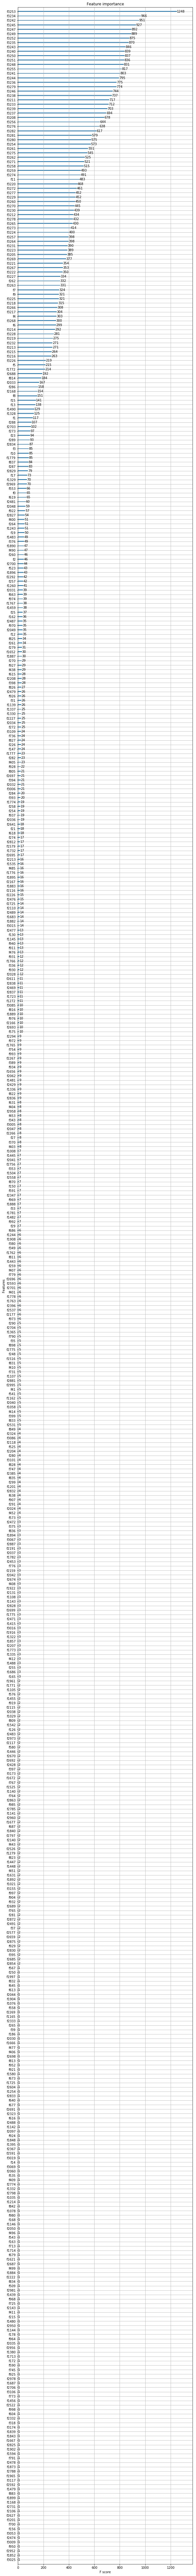

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 150.0)
xgb.plot_importance(booster=model); plt.show()

TODO:
* Tune params
* Better preprocess data
* stack the model as base with base+meta ?